**This Jupyter Notebook shows examples of loading AESR data**

**170919 RG** 

It is assumed that a mongod is running (on a remote raspi in this case, but could be local) with AESR data

_________________________



# Import Packages

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pprint
import time
import datetime
import math
matplotlib.rcParams['figure.figsize'] = (10,7) # Make plots appropriate size


# Test Plotting Works in Jupyter Notebook

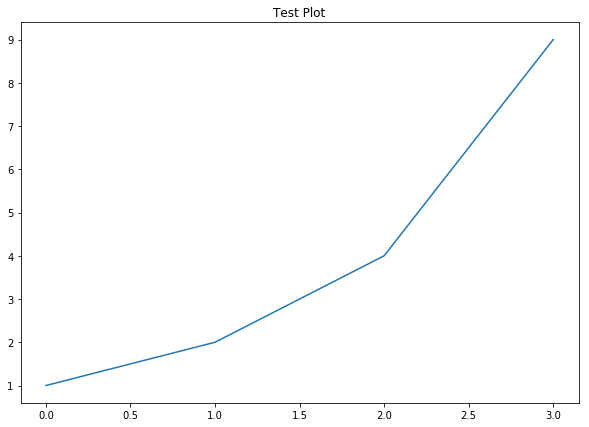

In [2]:
plt.plot([1,2,4,9]) # Check plotting is working
plt.title('Test Plot') # You see an inline plot below thanks to %matplotlib inline command

******
# Attach to Mongo Database with AESR Data (AESR_20170901T171332 contains very useful sensor data)

In [3]:
from pymongo import MongoClient
client = MongoClient('raspi0w1.local')
client.database_names()
# A list of all databases should appear

['AESR_20170901T170407',
 'local',
 'AESR_20170901T170946',
 'AESR_20170901T170354',
 'AESR_20170901T170958',
 'AESR_20170901T171332',
 'AESR_20170901T171242',
 'AESR_20170901T170455']

In [4]:
db = client.AESR_20170901T171332 # This dataset has a lot of useful data
db.collection_names() # List the colllections that are available

['log', 'system.indexes', 'data', 'wps']

In [5]:
c = db.data # Collection with all sensor data
# dir(c) # Check methods that are available on the collection

------

## Look at Individual Database Entries

In [6]:
first = c.find_one() # First element
pprint.pprint(first) # Look at detailed structure of first element

t1 = first['_id'].generation_time # Timestamp for first element
t1

# If you want to print each of the entries
# for x in c.find({'atype':'VOLT_MON'}):
#    pprint.pprint(x['param']['volt'])

{'_id': ObjectId('59a9cd86d6861b0c5cf8f1c5'),
 'atype': 'VOLT_MON',
 'itype': None,
 'param': {'dir_volt': 20837, 'volt': 11.356511573229165}}


datetime.datetime(2017, 9, 1, 21, 13, 42, tzinfo=<bson.tz_util.FixedOffset object at 0x11b5f1908>)

In [7]:
first['atype'] # Access data type

'VOLT_MON'

## Example loading Battery Voltage Data

In [8]:
# Want to add time calculation - seconds since start of sweep
# Build a new numpy array with the time in seconds since start and the voltage

data = []
for row in c.find({'atype':'VOLT_MON'}):
    data.append( [ 
        ( row['_id'].generation_time - first['_id'].generation_time ).total_seconds() 
        , row['param']['volt'] 
        ] )
    
x = np.array(data,dtype = np.dtype('f4') ) # Create an np array using 4 byte precision which is sufficient

x

array([[  0.00000000e+00,   1.13565111e+01],
       [  1.00000000e+00,   1.13570566e+01],
       [  2.00000000e+00,   1.13570566e+01],
       ..., 
       [  3.05400000e+03,   1.10442171e+01],
       [  3.05500000e+03,   1.10447617e+01],
       [  3.05600000e+03,   1.10447617e+01]], dtype=float32)

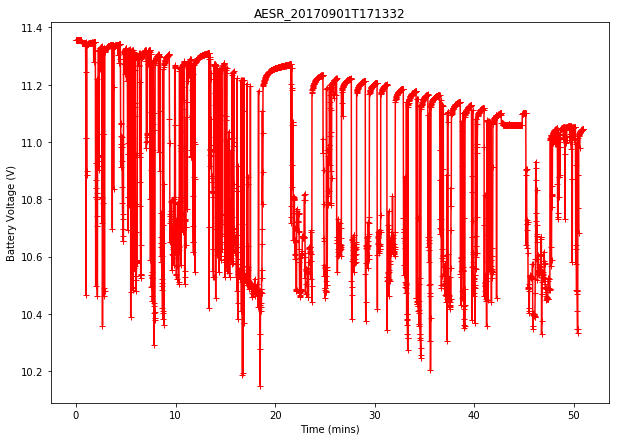

In [9]:
plt.plot( x[:,0] / 60. ,x[:,1] , 'r+-')
plt.xlabel('Time (mins)')
plt.ylabel('Battery Voltage (V)')
plt.title('AESR_20170901T171332')

## Look at list of all Types of Data Available in Collection and printing some of the records

In [10]:
for ii in c.distinct('atype'): # A list of distinct atype's
    print('%-12s    %4d'%(ii , c.find({'atype':ii}).count() )) # How many records of each type

VOLT_MON        3041
TEMP            3039
PRES            3041
ADC             3041
ENVIRON         3041
GPS             3041


In [11]:
ii = 0
for row in c.find():
    pprint.pprint(row)
    ii += 1
    if(ii>10):
        break


{'_id': ObjectId('59a9cd86d6861b0c5cf8f1c5'),
 'atype': 'VOLT_MON',
 'itype': None,
 'param': {'dir_volt': 20837, 'volt': 11.356511573229165}}
{'_id': ObjectId('59a9cd86d6861b0c5cf8f1c6'),
 'atype': 'TEMP',
 'itype': None,
 'param': {'temp_c': 21.335516902180075}}
{'_id': ObjectId('59a9cd86d6861b0c5cf8f1c7'),
 'atype': 'PRES',
 'itype': None,
 'param': {'pres_mbar': 1038.1482472815987, 'temp_c': 23.114565356689855}}
{'_id': ObjectId('59a9cd86d6861b0c5cf8f1c8'),
 'atype': 'ADC',
 'itype': None,
 'param': {'adc_val': 14356,
           'mgL': 11.518102066591386,
           'volt': 2.6918321481978817}}
{'_id': ObjectId('59a9cd86d6861b0c5cf8f1c9'),
 'atype': 'ENVIRON',
 'itype': None,
 'param': {'hum_per': 57.65068531450873,
           'pres_pas': 103282.40540673865,
           'temp_cel': 23.687578001251676}}
{'_id': ObjectId('59a9cd86d6861b0c5cf8f1ca'),
 'atype': 'GPS',
 'itype': None,
 'param': {'lat': 41.735506667, 'lon': -71.325178333}}
{'_id': ObjectId('59a9cd87d6861b0c5cf8f1cc'),
 'a

## Temperature ( degC ) vs Time

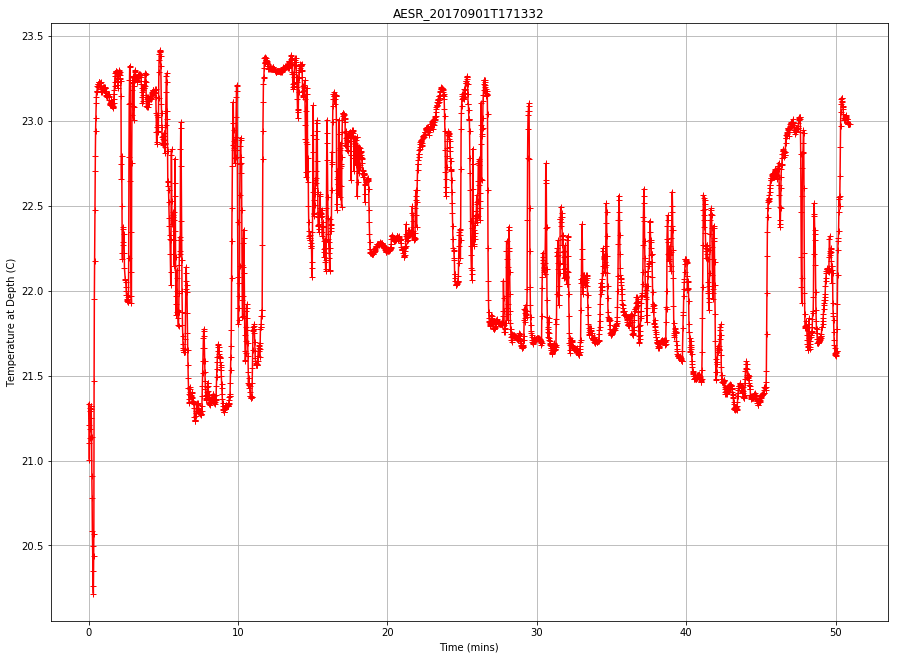

In [12]:
matplotlib.rcParams['figure.figsize'] = (15,11) # Reset plot size

sel_atype = 'TEMP'
sel_param = 'temp_c'
plot_ylabel = 'Temperature at Depth (C)'
plot_title = 'AESR_20170901T171332'
plot_scale = 1
plot_offset = 0.

data = []
for row in c.find({'atype':sel_atype}):
    data.append( [ 
        ( row['_id'].generation_time - first['_id'].generation_time ).total_seconds() 
        , row['param'][sel_param] 
        ] )
    
x = np.array(data,dtype = np.dtype('f4') ) # Create an np array using 4 byte precision which is sufficient

# Remove any bad reads from thermometer set
x = x[ x[:,1] > 0. , :]

plt.plot( x[:,0] / 60. ,plot_scale * x[:,1] - plot_offset , 'r+-')
plt.xlabel('Time (mins)')
plt.ylabel(plot_ylabel)
plt.title(plot_title)
plt.grid(True)

matplotlib.rcParams['figure.figsize'] = (10,7) # Reset plot size


## Pressure versus Time

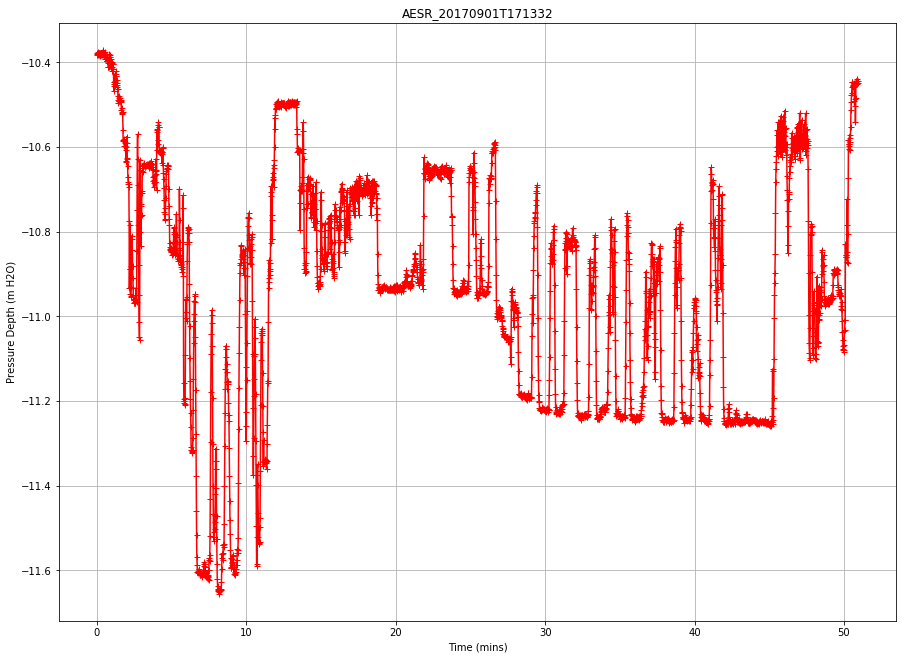

In [13]:
matplotlib.rcParams['figure.figsize'] = (15,11) # Reset plot size

sel_atype = 'PRES'
sel_param = 'pres_mbar'
plot_ylabel = 'Pressure Depth (m H2O)'
plot_title = 'AESR_20170901T171332'
plot_scale = -0.01
plot_offset = 0.

data = []
for row in c.find({'atype':sel_atype}):
    data.append( [ 
        ( row['_id'].generation_time - first['_id'].generation_time ).total_seconds() 
        , row['param'][sel_param] 
        ] )
    
x = np.array(data,dtype = np.dtype('f4') ) # Create an np array using 4 byte precision which is sufficient

plt.plot( x[:,0] / 60. ,plot_scale * x[:,1] - plot_offset , 'r+-')
plt.xlabel('Time (mins)')
plt.ylabel(plot_ylabel)
plt.title(plot_title)
plt.grid(True)

matplotlib.rcParams['figure.figsize'] = (10,7) # Reset plot size


## Oxygen Levels versus Time

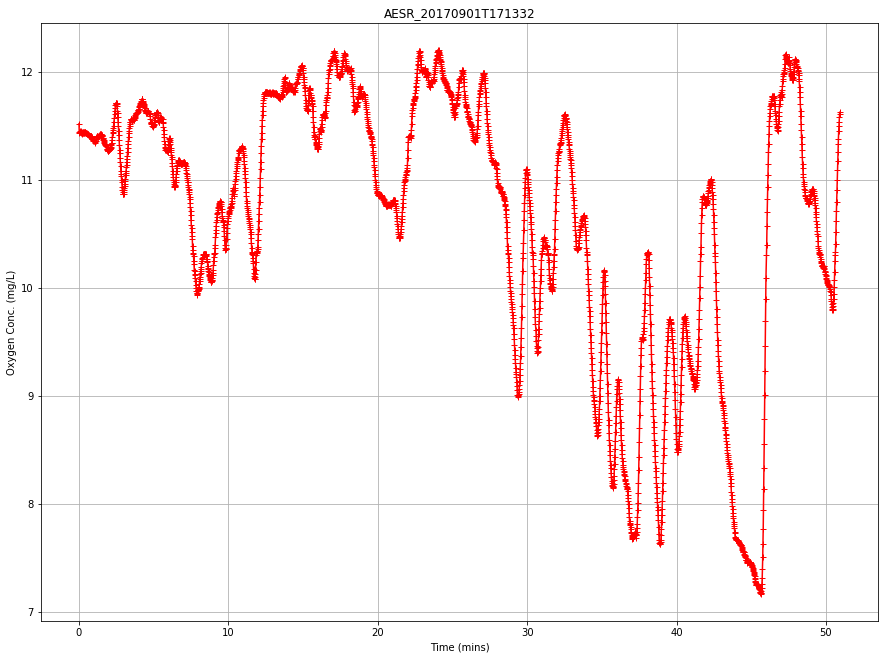

In [14]:
matplotlib.rcParams['figure.figsize'] = (15,11) # Reset plot size

sel_atype = 'ADC'
sel_param = 'mgL'
plot_ylabel = 'Oxygen Conc. (mg/L)'
plot_title = 'AESR_20170901T171332'
plot_scale = 1
plot_offset = 0.

data = []
for row in c.find({'atype':sel_atype}):
    data.append( [ 
        ( row['_id'].generation_time - first['_id'].generation_time ).total_seconds() 
        , row['param'][sel_param] 
        ] )
    
x = np.array(data,dtype = np.dtype('f4') ) # Create an np array using 4 byte precision which is sufficient

plt.plot( x[:,0] / 60. ,plot_scale * x[:,1] - plot_offset , 'r+-')
plt.xlabel('Time (mins)')
plt.ylabel(plot_ylabel)
plt.title(plot_title)
plt.grid(True)

matplotlib.rcParams['figure.figsize'] = (10,7) # Reset plot size


## GPS Coordinates (x,y) with time (minutes) also shown

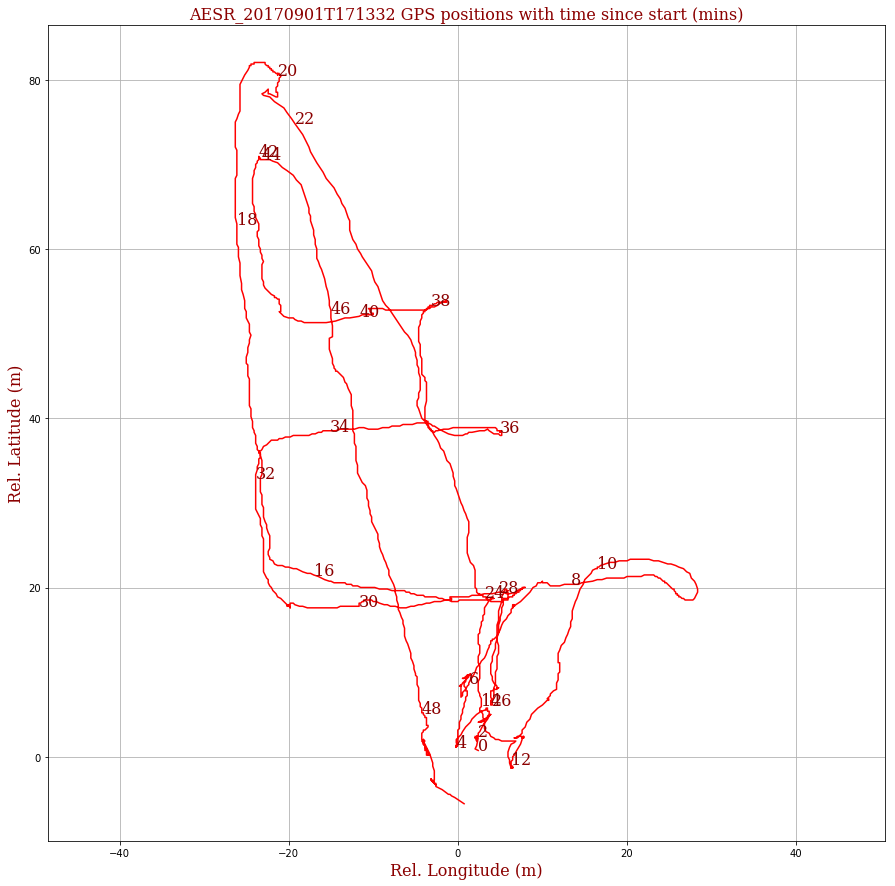

In [15]:
# A Plot of the path of AESR with number every 2 minutes of real time

matplotlib.rcParams['figure.figsize'] = (15,15) # Square plot for this map

# Look for these tags in the mongo collection
sel_atype = 'GPS'
sel_param1 = 'lon'
sel_param2 = 'lat'
plot_ylabel = 'Position'
plot_title = 'AESR_20170901T171332 GPS positions with time since start (mins)'

launch_lon_lat = [-71.3252 , 41.7355] # (0,0) meters position for the plot - this should be the beach used for launch

scale_deg_to_m = 6371e3/57.296 # Scaling for latitude from degrees to m local on the ground

# Font for the plot and text labels
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }


# BUILD A NUMPY ARRAY WITH COLUMNS OF THE RELEVANT DATA
data = []
for row in c.find({'atype':sel_atype}):
    data.append( [ 
    ( row['_id'].generation_time - first['_id'].generation_time ).total_seconds() 
        # Convert lon and lat to a local x,y coordinate
    , (row['param'][sel_param1]-launch_lon_lat[0]) * scale_deg_to_m # * math.cos( row['param'][sel_param2] ) # lon
    , (row['param'][sel_param2]-launch_lon_lat[1]) * scale_deg_to_m # lat
    ] )

x = np.array(data,dtype = np.dtype('f4') ) # Create an np array using 4 byte precision which is sufficient

plt.plot( x[:,1] , x[:,2] , 'r-')
plt.xlabel('Rel. Longitude (m)', fontdict = font)
plt.ylabel('Rel. Latitude (m)', fontdict = font)
plt.title(plot_title , fontdict = font )
plt.grid(True)
plt.axes().set_aspect('equal', 'datalim')

for ii in range(0,50,2):
    idx = (np.abs( x[:,0]/60. - ii)).argmin() # Find index of array entry closests to given time
    plt.text( x[idx,1] , x[idx,2] , str(ii) , fontdict = font )
    

matplotlib.rcParams['figure.figsize'] = (10,7) # Reset plot size

# Footnotes:
Taking inspiration from   https://github.com/Altons/pymongo-tutorial/blob/master/pymongo-tutorial.ipynb